# Función Schwefel 2.23

La **función Schwefel 2.23** es una función continua, diferenciable, no separable, escalable y unimodal. Está definida como:

$$ f(x) = \sum_{i=1}^{D} x_i^{10} $$

Donde:

$$ x_i \in [-10, 10] $$


La solución global conocida es:

$$ x^* = (0, 0, \dots, 0) $$ 
con $$ f(x^*) = 0 $$


In [1]:
import numpy as np

# Función objetivo
def schwefel_223(x):
    return np.sum(x**10)

# Gradiente de la función
def gradient(x):
    return 10 * x**9

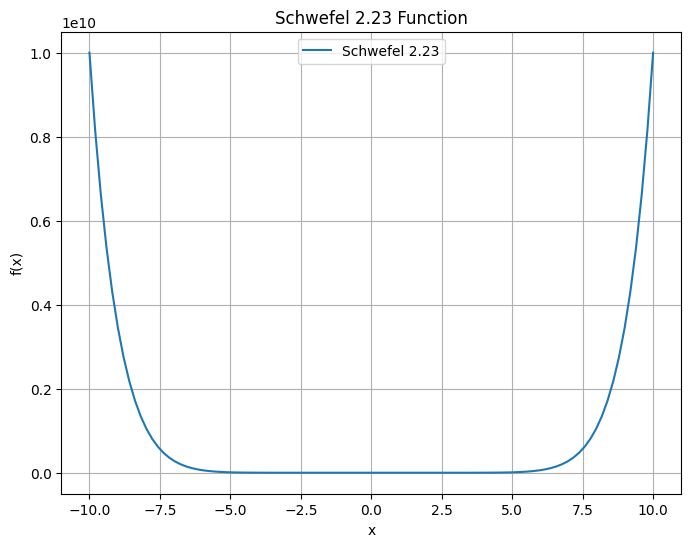

In [163]:
import matplotlib.pyplot as plt

# Definir la función schwefel_223
def schwefel_223(x):
    return np.sum(x**10)

# Generar valores de x para diferentes tamaños
x_values = np.linspace(-10, 10, 100)  # Puedes cambiar los límites y el número de puntos
y_values = []

# Evaluar la función para cada valor de x
for x in x_values:
    y_values.append(schwefel_223(np.array([x])))

# Graficar la función
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, label='Schwefel 2.23')
plt.title("Schwefel 2.23 Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.legend()
plt.show()


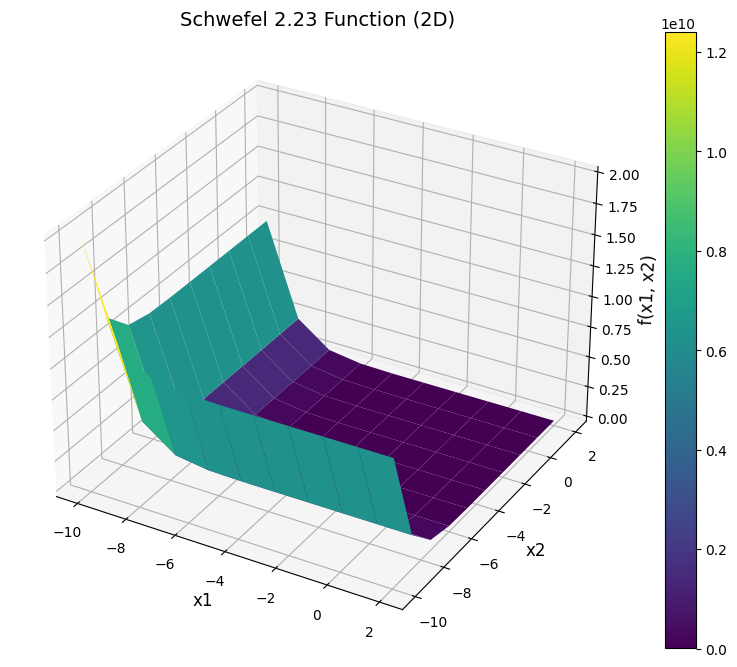

In [164]:
from mpl_toolkits.mplot3d import Axes3D

# Crear una cuadrícula de valores de x1 y x2
x1_values = np.linspace(-10, 2, 10)
x2_values = np.linspace(-10, 2, 10)
X1, X2 = np.meshgrid(x1_values, x2_values)

# Evaluar la función Schwefel 2.23 para cada par (x1, x2)
Z = np.array([schwefel_223(np.array([x1, x2])) for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
Z = Z.reshape(X1.shape)

# Crear la figura 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar la superficie
surf = ax.plot_surface(X1, X2, Z, cmap='viridis', edgecolor='none')

# Añadir etiquetas y título
ax.set_title("Schwefel 2.23 Function (2D)", fontsize=14)
ax.set_xlabel("x1", fontsize=12)
ax.set_ylabel("x2", fontsize=12)
ax.set_zlabel("f(x1, x2)", fontsize=12)

# Añadir barra de colores
fig.colorbar(surf)

plt.show()


In [2]:
import time

In [83]:
def iter_algorithm(times, run_algorithm, D):
    solutions = []
    run_times = []
    for i in range(times):
        solution, time = run_algorithm(D)
        solutions.append(solution)
        run_times.append(time)
    return solutions,run_times

def algorithm_per_dim(times, run_algorithm, num_dim):
    mean_solutions = []
    mean_times = []
    for d in range(num_dim):
        solutions,run_times = iter_algorithm(times,run_algorithm,d+1)
        mean_sol = np.mean(solutions)
        mean_time = np.mean(run_times)
        mean_solutions.append(mean_sol)
        mean_times.append(mean_time)
    return mean_solutions,mean_times

In [84]:
times = 5
num_dim = 20

### 1. **Algoritmo de Newton**
El **Método de Newton** utiliza el Hessiano (segunda derivada) para acelerar la convergencia.

#### Implementación:


In [128]:
def hessian(x):
    return np.diag(90 * x**8)

def newton_method(x0, max_iter=100, tol=1e-6):
    x = x0
    for _ in range(max_iter):
        grad = gradient(x)
        H = hessian(x)
        x_new = x - np.linalg.inv(H) @ grad
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
    return x, schwefel_223(x)

def run_newton_method(D):
    # Inicialización
    x0 = np.random.uniform(-10, 10, D)
    init_time = time.time()
    sol, val = newton_method(x0)
    end_time = time.time()
    # print(f"Solución: {sol}, Valor de la función: {val}")
    return val, end_time-init_time

newton_sols, newton_times = algorithm_per_dim(times, run_newton_method, num_dim)


### 2. **Evolución Diferencial**
La **Evolución Diferencial** es un algoritmo bioinspirado que optimiza utilizando una población de soluciones.

#### Implementación con SciPy:


In [87]:
from scipy.optimize import differential_evolution

def run_differential_evolution(D):
    # Inicialización
    bounds = [(-10, 10)] * D  # Definir los límites para cada variable
    init_time = time.time()
    result = differential_evolution(schwefel_223, bounds)
    end_time = time.time()
    # print(f"Solución: {result.x}, Valor de la función: {result.fun}")
    return result.fun, end_time-init_time

diff_evol_sols, diff_evol_times = algorithm_per_dim(times, run_differential_evolution, num_dim)




### 3. **Algoritmo Genético**
El **Algoritmo Genético** usa selección, cruce y mutación para explorar el espacio de soluciones.

#### Implementación con DEAP:



In [155]:
import time
import random
import numpy as np
from deap import base, creator, tools, algorithms

# Definir las clases solo una vez
if not hasattr(creator, "FitnessMin"):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    
if not hasattr(creator, "Individual"):
    creator.create("Individual", list, fitness=creator.FitnessMin)

# Definir la función schwefel_223
def schwefel_223_(individual):
    return (np.sum(np.array(individual) ** 10),)

# Definir el algoritmo genético
def run_genetic_algorithm(D):

    random.seed(42)

    # Crear la caja de herramientas para el algoritmo genético
    toolbox = base.Toolbox()

    # Definir los atributos del individuo (valores en el rango [-10, 10])
    toolbox.register("attr_float", random.uniform, -10, 10)
    # Definir un individuo que es una lista de floats
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=D)
    # Definir una población (lista de individuos)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Definir la función objetivo
    toolbox.register("evaluate", schwefel_223_)
    # Definir los operadores genéticos (selección, cruce y mutación)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=100, indpb=0.1)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # Inicializar la población
    population = toolbox.population(n=100)
    
    # Definir los parámetros del algoritmo genético
    cxpb, mutpb, ngen = 0.5, 0.2, 40

    init_time = time.time()
    # Ejecutar el algoritmo genético
    algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, verbose=False)
    end_time = time.time()
    
    # Obtener el mejor individuo
    best_individual = tools.selBest(population, k=1)[0]
    return best_individual.fitness.values[0], end_time - init_time

genetic_alg_sols, genetic_alg_times = algorithm_per_dim(times, run_genetic_algorithm, num_dim)


### 4. **Optimización por Enjambre de Partículas (PSO)**
PSO simula el comportamiento social de las partículas buscando una solución óptima.

#### Implementación con Pyswarm:

In [89]:
from pyswarm import pso

def run_particle_swarm(D):
    # Definir límites de las variables
    lb = [-10] * D
    ub = [10] * D

    init_time = time.time()
    # Ejecutar PSO
    best_position, best_value = pso(schwefel_223, lb, ub)
    end_time = time.time()
    # print(f"Solución: {best_position}, Valor de la función: {best_value}")
    return best_value,end_time-init_time

particle_swarm_sols, particle_swarm_times = algorithm_per_dim(times, run_particle_swarm, num_dim)


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm b

### 5. **Búsqueda Simulada (Simulated Annealing)**
La **Búsqueda Simulada** acepta soluciones peores en las primeras iteraciones para evitar quedarse en mínimos locales.

#### Implementación con SciPy:


In [90]:
from scipy.optimize import dual_annealing

def run_simulated_annealing(D):
    bounds = [(-10, 10)] * D
    init_time = time.time()
    result = dual_annealing(schwefel_223, bounds)
    end_time = time.time()
    # print(f"Solución: {result.x}, Valor de la función: {result.fun}")
    return result.fun, end_time-init_time

sim_annealing_sols, sim_annealing_times = algorithm_per_dim(times, run_simulated_annealing, num_dim)


## Comparación de algoritmos mediante gráficas

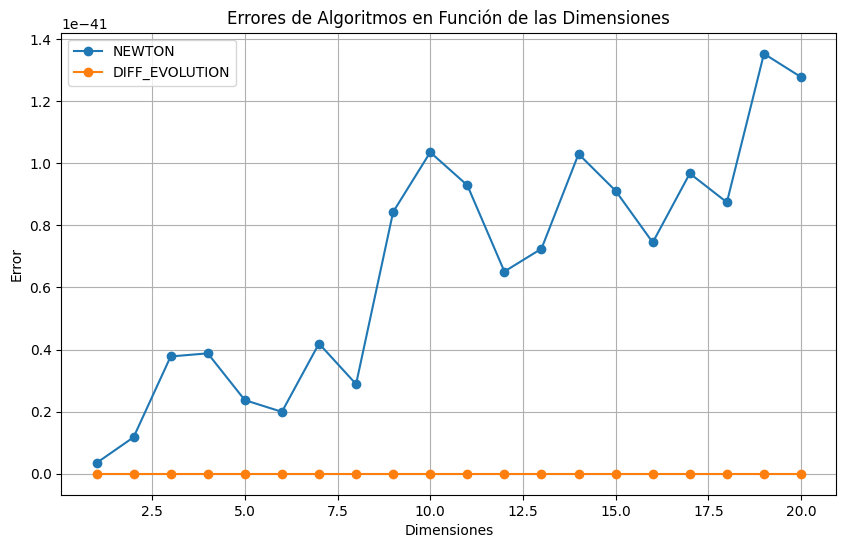

In [157]:
import matplotlib.pyplot as plt
dimensions = np.arange(1, 21)  # Dimensiones de 1 a 20

# Crear el gráfico
plt.figure(figsize=(10, 6))
np.abs
# Graficar cada conjunto de errores
plt.plot(dimensions, np.abs(newton_sols), marker='o', label='NEWTON')
plt.plot(dimensions, np.abs(diff_evol_sols), marker='o', label='DIFF_EVOLUTION')
# plt.plot(dimensions, np.abs(sim_annealing_sols), marker='o', label='SIM_ANNEALING')

# Configurar los ejes y la leyenda
plt.xlabel('Dimensiones')
plt.ylabel('Error')
plt.title('Errores de Algoritmos en Función de las Dimensiones')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

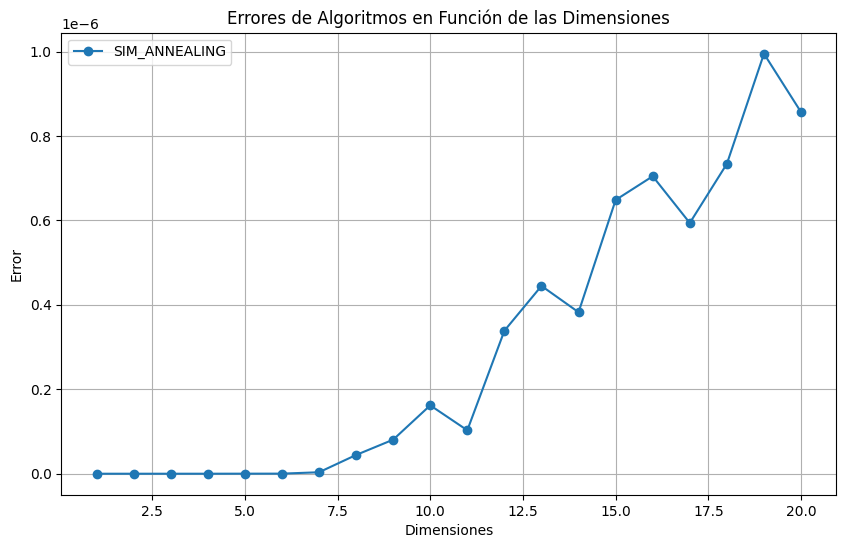

In [145]:
import matplotlib.pyplot as plt
dimensions = np.arange(1, 21)  # Dimensiones de 1 a 20

# Crear el gráfico
plt.figure(figsize=(10, 6))
np.abs
# Graficar cada conjunto de errores
plt.plot(dimensions, np.abs(sim_annealing_sols), marker='o', label='SIM_ANNEALING')

# Configurar los ejes y la leyenda
plt.xlabel('Dimensiones')
plt.ylabel('Error')
plt.title('Errores de Algoritmos en Función de las Dimensiones')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

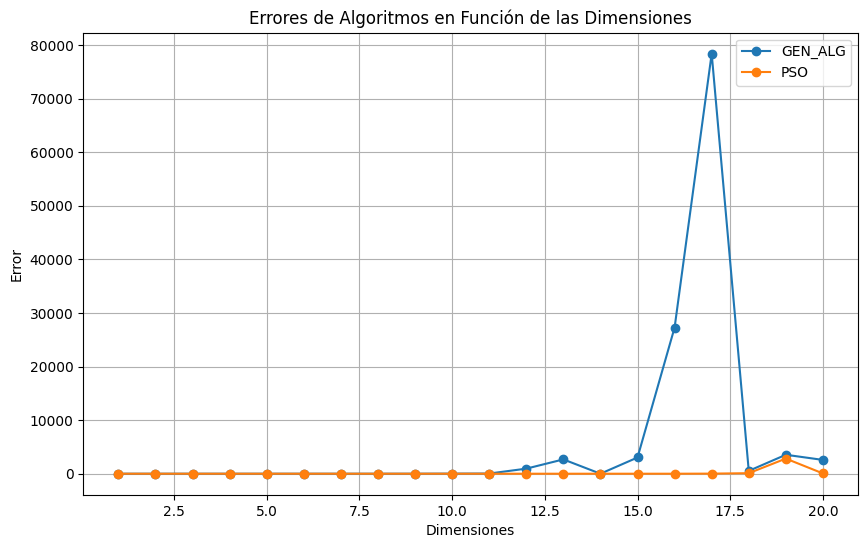

In [158]:
import matplotlib.pyplot as plt
dimensions = np.arange(1, 21)  # Dimensiones de 1 a 20

# Crear el gráfico
plt.figure(figsize=(10, 6))
np.abs
# Graficar cada conjunto de errores
plt.plot(dimensions, np.abs(genetic_alg_sols), marker='o', label='GEN_ALG')
plt.plot(dimensions, np.abs(particle_swarm_sols), marker='o', label='PSO')

# Configurar los ejes y la leyenda
plt.xlabel('Dimensiones')
plt.ylabel('Error')
plt.title('Errores de Algoritmos en Función de las Dimensiones')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

### Conclusiones respecto a la similitud con el mínimo global:
- Los mejores resultados fueron obtenidos por la **Evolución Diferencial** y el **Método de Newton**. 
- La **Evolución Diferencial** se mantiene con error 0 para dimensiones menores a 20 y para mayores el error es mínimo. 
- A su vez, los errores del **Método de Newton** oscilan entre valores muy bajos.

In [166]:
print(diff_evol_sols)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.819228734479438e-138]


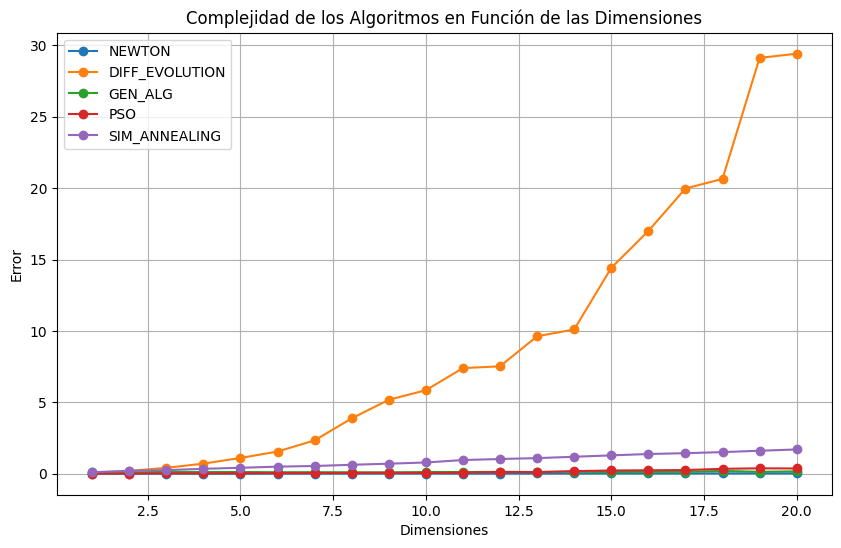

In [159]:
import matplotlib.pyplot as plt
dimensions = np.arange(1, 21)  # Dimensiones de 1 a 20

# Crear el gráfico
plt.figure(figsize=(10, 6))
np.abs
# Graficar cada conjunto de errores
plt.plot(dimensions, newton_times, marker='o', label='NEWTON')
plt.plot(dimensions, diff_evol_times, marker='o', label='DIFF_EVOLUTION')
plt.plot(dimensions,genetic_alg_times, marker='o', label='GEN_ALG')
plt.plot(dimensions, particle_swarm_times, marker='o', label='PSO')
plt.plot(dimensions, sim_annealing_times, marker='o', label='SIM_ANNEALING')
# plt.plot(dimensions, np.abs(sim_annealing_sols), marker='o', label='SIM_ANNEALING')

# Configurar los ejes y la leyenda
plt.xlabel('Dimensiones')
plt.ylabel('Error')
plt.title('Complejidad de los Algoritmos en Función de las Dimensiones')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

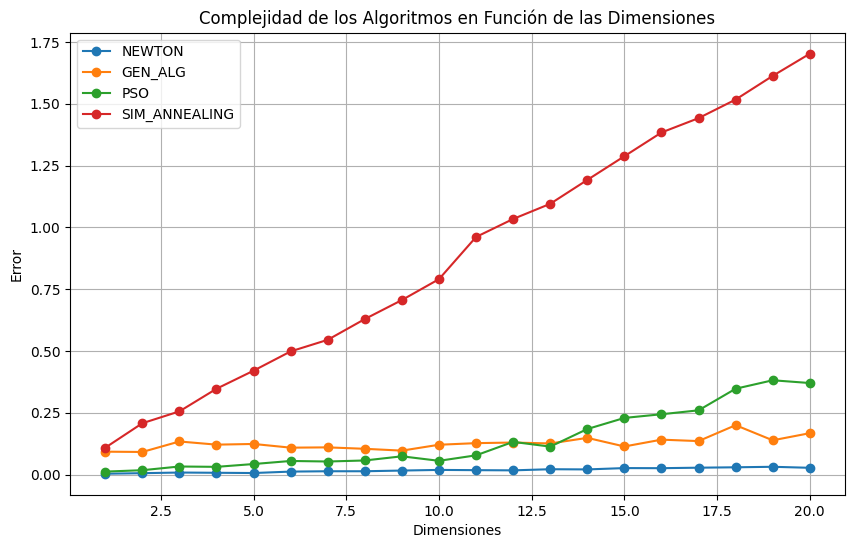

In [161]:
import matplotlib.pyplot as plt
dimensions = np.arange(1, 21)  # Dimensiones de 1 a 20

# Crear el gráfico
plt.figure(figsize=(10, 6))
np.abs
# Graficar cada conjunto de errores
plt.plot(dimensions, newton_times, marker='o', label='NEWTON')
plt.plot(dimensions,genetic_alg_times, marker='o', label='GEN_ALG')
plt.plot(dimensions, particle_swarm_times, marker='o', label='PSO')
plt.plot(dimensions, sim_annealing_times, marker='o', label='SIM_ANNEALING')

# Configurar los ejes y la leyenda
plt.xlabel('Dimensiones')
plt.ylabel('Error')
plt.title('Complejidad de los Algoritmos en Función de las Dimensiones')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

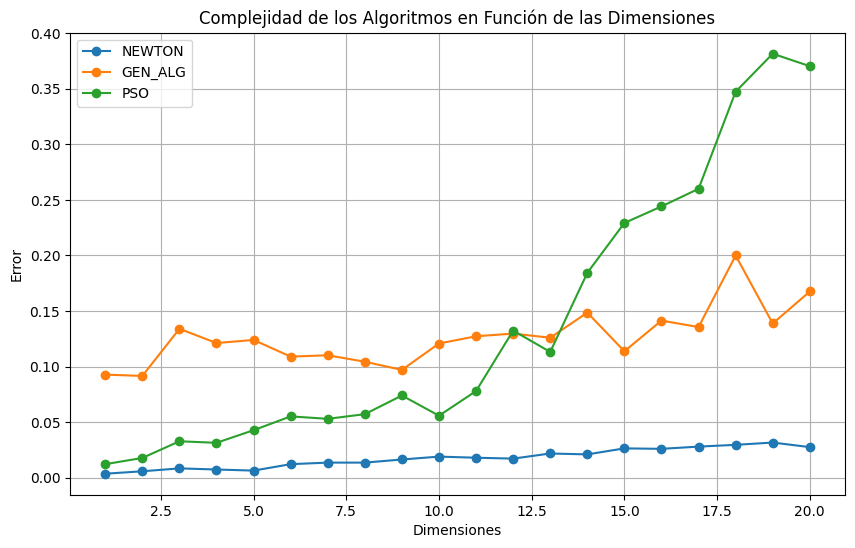

In [165]:
import matplotlib.pyplot as plt
dimensions = np.arange(1, 21)  # Dimensiones de 1 a 20

# Crear el gráfico
plt.figure(figsize=(10, 6))
np.abs
# Graficar cada conjunto de errores
plt.plot(dimensions, newton_times, marker='o', label='NEWTON')
plt.plot(dimensions,genetic_alg_times, marker='o', label='GEN_ALG')
plt.plot(dimensions, particle_swarm_times, marker='o', label='PSO')

# Configurar los ejes y la leyenda
plt.xlabel('Dimensiones')
plt.ylabel('Error')
plt.title('Complejidad de los Algoritmos en Función de las Dimensiones')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

### Conclusiones respecto a la complejidad temporal:
- A medida que aumenta la dimensión para cada uno de estos algoritmos aumenta la complejidad temporal, ya que las operaciones se hacen más costosas con más dimensiones
- La **Evolución Diferencial** es el algoritmo cuya complejidad aumenta en mayor proporción a medida que aumentan las dimensiones, mientras que el **Método de Newton** mantiene la menor complejidad para todas las dimensiones y presenta un aumento mínimo en la de esta
- El **Algoritmo Genético** para dimensiones menores a 12 presenta una complejidad relativamente baja pero con el aumento de las dimensiones posteriores se ve afectada su rapidez

## Mejor Algoritmo:     *"Método de Newton"*
- Presenta los mejores resultados en relación cercanía con el mínimo global y complejidad temporal del algoritmo. A pesar de que la **Evolución Diferencial** muestra valores más cercanos al mínimo global, en costo computacional no es un algoritmo útil para dimensiones muy grandes. Como el **Método de Newton** dista en una proporción muy pequeña del mínimo global y es el algoritmo más eficiente, promete resultados extraordinarios para dimensiones de gran valor.

